In [1]:
# RNN으로 IMDB 리뷰 분류하기
# 총 50000개 샘플 -> 정수로 바꾼 데이터 사용

# 데이터 준비
from keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=200)

2025-08-28 13:11:53.228130: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 13:11:53.409673: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-28 13:11:53.409715: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-28 13:11:53.410398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 13:11:53.464372: I tensorflow/core/platform/cpu_feature_g

In [2]:
# 훈련세트 테스트세트 크기확인
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [3]:
# 1차원 배열에 파이썬 리스트로 담아야 메모리를 효율적으로 사용가능

# 첫 번째 리뷰의 길이 출력
print(len(train_input[0])) # 218개 토큰
# 두 번째 리뷰의 길이 출력
print(len(train_input[1])) # 189개 토큰

218
189


In [4]:
# 첫 번째 리뷰내용 출력
print(train_input[0])
# 전체 어휘 사전에 있는 단어를 등장 횟수 순서대로 나열한 다음 가장 많이 등장한 200개의 단어 선택 -> 없는 단어는 2로 표시

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 2, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 2, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 2, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 2, 92, 25, 104, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [5]:
# 타깃 데이터 출력
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [6]:
# 훈련세트에서 검증세트 분리
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [7]:
# 리뷰의 길이 확인을 위해 넘파이 배열에 담기
import numpy as np

lengths = np.array([len(x) for x in train_input])

# 리뷰 길이의 평균값과 중간값
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


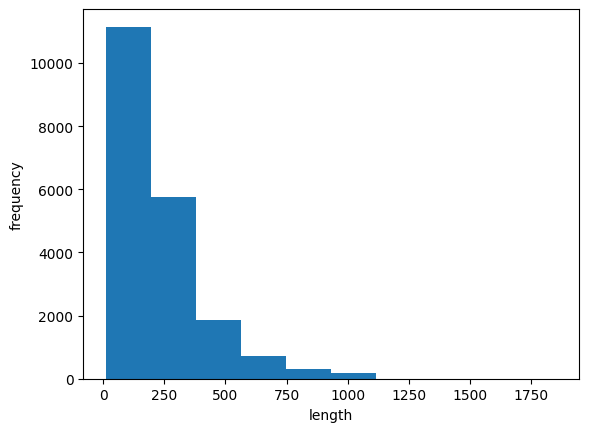

In [8]:
# 리뷰 길이 데이터의 분포 확인
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [9]:
# 리뷰의 길이가 대부분 짧으므로 100개의 단어만 사용하도록 함
# 100개의 단어보다 작은 리뷰는 패딩을 이용하여 토큰으로 0을 사용하도록 함
from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100) # 시퀀스 데이터의 길이를 맞추는 pad_sequences()함수사용

# 패딩 결과 확인
print(train_seq.shape) # (20000,100)크기의 2차원 배열

(20000, 100)


In [10]:
# train_seq의 첫 번째 샘플 출력
print(train_seq[0]) 

[ 10   4  20   9   2   2   2   5  45   6   2   2  33   2   8   2 142   2
   5   2  17  73  17   2   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12   2  69   2 142  73   2   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [11]:
# 패딩값이 없기 때문에 100보다 길었음을 확인
# 패딩으로 앞이 잘렸는지, 뒤가 잘렸는지 원본데이터를 슬라이싱해서 확인
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


In [12]:
# 샘플의 앞부분이 잘렸음을 확인 할 수 있음
# why? 일반적으로 시퀀스의 뒷부분의 정보가 더 유용할 것이라고 기대하기 떄문
# 뒷 부분을 자르고 싶다면 -> pad_sequences()함수의 truncating 매개변수를 기본값 'pre'->'post'로 변경

In [13]:
# 여섯번째 샘플 출력
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71   2   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14   2  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94   2   2  10  10  87   2  34  49   2   7   2   2   2
   2   2   2   2  46  48  64  18   4   2]


In [14]:
# 앞 부분에 0이 있기 때문에 샘플의 길이는 100이 안됨
# 시퀀스의 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향을 미치게 되므로 앞에 패딩을 추가하는 것을 선호
# 뒷 분에 추가하고 싶다면 -> ad_sequences()함수의 padding 매개변수를 기본값 'pre'->'post'로 변경

In [15]:
# 검증 세트의 길이도 100으로 맞추기
val_seq = pad_sequences(val_input, maxlen=100)

In [30]:
# RNN 구현
import keras

model = keras.Sequential()
model.add(keras.layers.Input(shape=(100,200))) # (시퀀스 길이, 한 단어의 feature크기)
model.add(keras.layers.SimpleRNN(8)) # 뉴런의 개수 지정, 활성화 함수 -> 기본값인 tanh 사용
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [31]:
# keras의 유틸리티를 사용하여 자동으로 원-핫 인코딩
train_oh = keras.utils.to_categorical(train_seq)
# 배열의 크기확인
print(train_oh.shape)

(20000, 100, 200)


In [18]:
# train_oh의 첫 번쨰 샘플의 첫 번째 토큰 확인
print(train_oh[0][0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
# val_seq(검증세트)도 원-핫인코딩으로 변환
val_oh = keras.utils.to_categorical(val_seq)

In [20]:
# 모델 구조확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 1672      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 1681 (6.57 KB)
Trainable params: 1681 (6.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# 파라미터 개수
# 입력토큰인 200차원의 원-핫 인코딩 배열이 8개의 뉴런과 연결됨 -> 200*8
# 순환층의 hidden state는 다시 다음 타임스텝에 사용됨 -> 8*8  모든 뉴런이 서로 연결되는 fully connected 구조, 이전 히든스테이트와 현재 뉴런과 연결하려면 8*8 행렬이 돼야함
# 뉴런마다 하나의 절편을 가짐 -> 8
# 총 1600 + 64 + 8 = 1672개의 모델 파라미터 필요 
# (D × H + H × H + H)

In [25]:
# RNN 훈련
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 13s 37ms/step - loss: 0.6221 - accuracy: 0.6569 - val_loss: 0.5863 - val_accuracy: 0.6982
Epoch 2/100
  3/313 [..............................] - ETA: 10s - loss: 0.5960 - accuracy: 0.6927

/home/parkwooyeol/workspace/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 12s 37ms/step - loss: 0.5866 - accuracy: 0.6977 - val_loss: 0.5809 - val_accuracy: 0.7038
Epoch 3/100
313/313 [==============================] - 11s 34ms/step - loss: 0.5646 - accuracy: 0.7160 - val_loss: 0.5716 - val_accuracy: 0.7106
Epoch 4/100
313/313 [==============================] - 12s 37ms/step - loss: 0.5573 - accuracy: 0.7214 - val_loss: 0.5573 - val_accuracy: 0.7210
Epoch 5/100
313/313 [==============================] - 12s 40ms/step - loss: 0.5525 - accuracy: 0.7256 - val_loss: 0.5474 - val_accuracy: 0.7246
Epoch 6/100
313/313 [==============================] - 12s 38ms/step - loss: 0.5476 - accuracy: 0.7321 - val_loss: 0.5638 - val_accuracy: 0.7156
Epoch 7/100
313/313 [==============================] - 12s 38ms/step - loss: 0.5443 - accuracy: 0.7311 - val_loss: 0.5504 - val_accuracy: 0.7286
Epoch 8/100
313/313 [==============================] - 11s 35ms/step - loss: 0.5410 - accuracy: 0.7358 - val_loss: 0.5676 - val_accuracy: 0.71

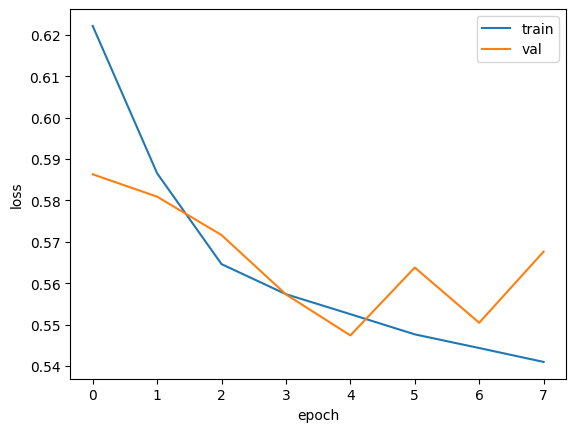

In [ ]:
# 검증세트에 대한 정확도 약 71%

# 훈련손실과 검증손실 그래프
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 원-핫 인코딩으로 변환한 데이터의 크기 확인
print(train_seq.nbytes, train_oh.nbytes) # 너무 큰 데이터

8000000 1600000000


In [32]:
# 단어 임베딩 사용
# 단어 임베딩은 각 단어를 고정된 크기의 실수 벡터로 바꾸어 줌
# 입력으로 정수 데이터를 받음 -> train_seq 사용가능 -> 메모리 절약

In [33]:
# 단어 임베딩을 위한 데이터셋 준비
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [34]:
# Embedding 클래스를 simpleRNN 층 앞에 추가한 두 번째 RNN 구현
model_emb = keras.Sequential()
model_emb.add(keras.layers.Input(shape=(100,))) # train_seq 그대로 사용
model_emb.add(keras.layers.Embedding(500,16)) # (어휘사전크기,임베딩벡터크기)
model_emb.add(keras.layers.SimpleRNN(8))
model_emb.add(keras.layers.Dense(1, activation='sigmoid'))

In [35]:
# 모델 구조확인
model_emb.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8209 (32.07 KB)
Trainable params: 8209 (32.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 파리미터 개수
# embedding class -> 500(사전크기)*16(벡터크기) = 8000개 
# simpleRNN class ->  16(벡터크기)*8(뉴런) + 8*8(hidden state) + 8(bias) = 200개 
# Dense -> 9개

In [36]:
# RNN 훈련
model_emb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model_emb.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 22s 67ms/step - loss: 0.5764 - accuracy: 0.7038 - val_loss: 0.5085 - val_accuracy: 0.7602
Epoch 2/100
  2/313 [..............................] - ETA: 15s - loss: 0.5109 - accuracy: 0.7500

/home/parkwooyeol/workspace/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 17s 55ms/step - loss: 0.4821 - accuracy: 0.7789 - val_loss: 0.4800 - val_accuracy: 0.7756
Epoch 3/100
313/313 [==============================] - 16s 50ms/step - loss: 0.4553 - accuracy: 0.7916 - val_loss: 0.4757 - val_accuracy: 0.7724
Epoch 4/100
313/313 [==============================] - 15s 49ms/step - loss: 0.4484 - accuracy: 0.7965 - val_loss: 0.5062 - val_accuracy: 0.7494
Epoch 5/100
313/313 [==============================] - 15s 49ms/step - loss: 0.4383 - accuracy: 0.8034 - val_loss: 0.4893 - val_accuracy: 0.7636
Epoch 6/100
313/313 [==============================] - 16s 50ms/step - loss: 0.4194 - accuracy: 0.8139 - val_loss: 0.4728 - val_accuracy: 0.7768
Epoch 7/100
313/313 [==============================] - 15s 49ms/step - loss: 0.4105 - accuracy: 0.8166 - val_loss: 0.4894 - val_accuracy: 0.7720
Epoch 8/100
313/313 [==============================] - 15s 48ms/step - loss: 0.4030 - accuracy: 0.8252 - val_loss: 0.4968 - val_accuracy: 0.77

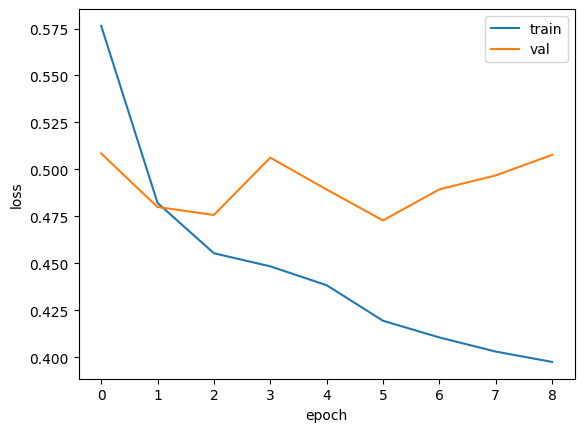

In [37]:
# 원-핫 인코딩을 사용한 모델보다 더 나은 성능 확인

# 훈련손실과 검증손실 그래프
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()